In [2]:
import numpy as np
import pandas as pd

from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt

from tqdm import tqdm

# **Fonctions utiles**

## **Affichage d'image**

In [3]:
def show_middle_slices(volume):
    # volume shape : (X, Y, Z)
    mid_x = volume.shape[0] // 2
    mid_y = volume.shape[1] // 2
    mid_z = volume.shape[2] // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Coupe axiale (XY plane à profondeur z)
    axes[0].imshow(volume[:, :, mid_z].T, cmap='gray')  # transpose pour que X horizontal, Y vertical
    axes[0].set_title(f'Axiale (z={mid_z})')
    axes[0].axis('on')

    # Coupe coronale (XZ plane à coordonnée y)
    axes[1].imshow(volume[:, mid_y, :].T, cmap='gray')  # transpose pour X horizontal, Z vertical
    axes[1].set_title(f'Coronale (y={mid_y})')
    axes[1].axis('on')

    # Coupe sagittale (YZ plane à coordonnée x)
    axes[2].imshow(volume[mid_x, :, :].T, cmap='gray')  # transpose pour Y horizontal, Z vertical
    axes[2].set_title(f'Sagittale (x={mid_x})')
    axes[2].axis('on')

    plt.tight_layout()
    plt.show()

## **Data augmentation**

In [4]:
def random_deformation(volume, grid_size=3, max_displacement=3):
    """
    Applique une déformation aléatoire 3D sur un volume cubique.

    Parameters
    ----------
    volume : np.ndarray
        Volume d'entrée (par ex. 48x48x48).
    grid_size : int
        Taille de la grille de contrôle (par défaut 3x3x3).
    max_displacement : float
        Amplitude maximale du déplacement (en voxels).
    """
    shape = volume.shape
    assert len(shape) == 3, "Le volume doit être 3D"

    # Coordonnées originales du volume
    dz, dy, dx = shape
    z, y, x = np.meshgrid(
        np.linspace(0, dz-1, shape[0]),
        np.linspace(0, dy-1, shape[1]),
        np.linspace(0, dx-1, shape[2]),
        indexing="ij"
    )

    # Génère une grille de points de contrôle (par ex. 3x3x3)
    grid_z = np.linspace(0, dz-1, grid_size)
    grid_y = np.linspace(0, dy-1, grid_size)
    grid_x = np.linspace(0, dx-1, grid_size)
    control_points = np.meshgrid(grid_z, grid_y, grid_x, indexing="ij")

    # Crée un champ de déplacements aléatoires
    # (même taille que la grille de contrôle)
    displacement = [
        np.random.uniform(-max_displacement, max_displacement, size=(grid_size,grid_size,grid_size))
        for _ in range(3)
    ]

    # Interpolation spline cubique du champ de déplacement
    from scipy.interpolate import RegularGridInterpolator
    disp_interp = [
        RegularGridInterpolator((grid_z, grid_y, grid_x), d, bounds_error=False, fill_value=0)
        for d in displacement
    ]

    # Calcule le champ de coordonnées déformées
    coords = np.array([z, y, x])
    dz_new = disp_interp[0](np.array([z.flatten(), y.flatten(), x.flatten()]).T).reshape(shape)
    dy_new = disp_interp[1](np.array([z.flatten(), y.flatten(), x.flatten()]).T).reshape(shape)
    dx_new = disp_interp[2](np.array([z.flatten(), y.flatten(), x.flatten()]).T).reshape(shape)

    z_new = z + dz_new
    y_new = y + dy_new
    x_new = x + dx_new

    # Applique la déformation au volume
    deformed = map_coordinates(volume, [z_new, y_new, x_new], order=3, mode='reflect')

    return deformed


In [34]:
def data_augmentation(volume):

    augmented_volumes = []
    for i in range(12):
        vol_def = random_deformation(volume)
        augmented_volumes.append(vol_def)
    
    augmented_volumes = np.stack(augmented_volumes)  # shape = (12, 48, 48, 48)
    return augmented_volumes

In [28]:
def dataset_augmented(volumes):
    liste_cubes = []
     
    for i in tqdm(range(len(volumes))):
        volume = volumes[i]  # shape (48,48,48)
        
        # data_augmentation doit renvoyer (n, 48, 48, 48)
        aug = data_augmentation(volume)
        
        liste_cubes.append(aug)

    # Concaténer tous les résultats en un seul tableau
    liste_cubes = np.concatenate(liste_cubes, axis=0)  # shape (N*n, 48, 48, 48)
    return liste_cubes

# **Data Augmentation**

In [6]:
hard_neg_1=np.load("/kaggle/input/hard-negatives-03-09/hard_negatives_1.npy")
hard_neg_2=np.load("/kaggle/input/hard-negatives-03-09/hard_negatives_2.npy")
hard_neg_3=np.load("/kaggle/input/hard-negatives-03-09/hard_negatives_3.npy")
hard_neg_4=np.load("/kaggle/input/hard-negatives-03-09/hard_negatives_4.npy")
hard_neg_5=np.load("/kaggle/input/hard-negatives-03-09/hard_negatives_5.npy")
hard_neg=np.concatenate([hard_neg_1,hard_neg_2,hard_neg_3,hard_neg_4,hard_neg_5], axis=0)

cubes_aneurysm_1=np.load("/kaggle/input/cubes-03-09/cubes_aneurysm_1.npy")
cubes_aneurysm_2=np.load("/kaggle/input/cubes-03-09/cubes_aneurysm_2.npy")
cubes_aneurysm_3=np.load("/kaggle/input/cubes-03-09/cubes_aneurysm_3.npy")
cubes_aneurysm_4=np.load("/kaggle/input/cubes-03-09/cubes_aneurysm_4.npy")
cubes_aneurysm_5=np.load("/kaggle/input/cubes-03-09/cubes_aneurysm_5.npy")
cubes_aneurysm=np.concatenate([cubes_aneurysm_1,cubes_aneurysm_2,cubes_aneurysm_3,cubes_aneurysm_4,cubes_aneurysm_5],axis=0)

cubes_closest_1=np.load("/kaggle/input/cubes-03-09/cubes_closest_1.npy")
cubes_closest_2=np.load("/kaggle/input/cubes-03-09/cubes_closest_2.npy")
cubes_closest_3=np.load("/kaggle/input/cubes-03-09/cubes_closest_3.npy")
cubes_closest_4=np.load("/kaggle/input/cubes-03-09/cubes_closest_4.npy")
cubes_closest_5=np.load("/kaggle/input/cubes-03-09/cubes_closest_5.npy")
cubes_closest=np.concatenate([cubes_closest_1,cubes_closest_2,cubes_closest_3,cubes_closest_4,cubes_closest_5],axis=0)

cubes_random_1=np.load("/kaggle/input/cubes-03-09/cubes_random_1.npy")
cubes_random_2=np.load("/kaggle/input/cubes-03-09/cubes_random_2.npy")
cubes_random_3=np.load("/kaggle/input/cubes-03-09/cubes_random_3.npy")
cubes_random_4=np.load("/kaggle/input/cubes-03-09/cubes_random_4.npy")
cubes_random_5=np.load("/kaggle/input/cubes-03-09/cubes_random_5.npy")
cubes_random=np.concatenate([cubes_random_1,cubes_random_2,cubes_random_3,cubes_random_4,cubes_random_5],axis=0)

In [7]:
print(f'hard_neg.shape : {hard_neg.shape}')
print(f'cubes_aneurysm.shape : {cubes_aneurysm.shape}')
print(f'cubes_closest.shape : {cubes_closest.shape}')
print(f'cubes_random.shape : {cubes_random.shape}')

hard_neg.shape : (166, 48, 48, 48)
cubes_aneurysm.shape : (84, 48, 48, 48)
cubes_closest.shape : (2100, 48, 48, 48)
cubes_random.shape : (2100, 48, 48, 48)


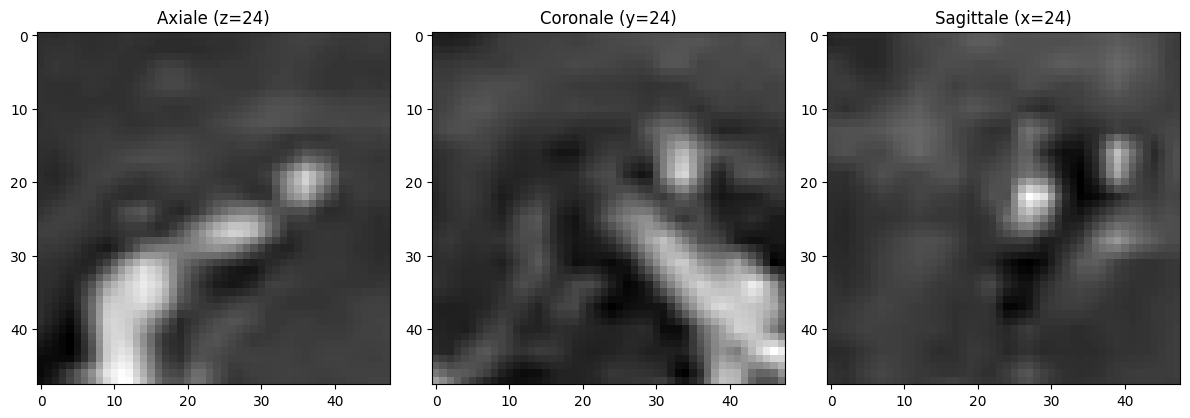

In [16]:
cube_test=cubes_aneurysm[7]
show_middle_slices(cube_test)

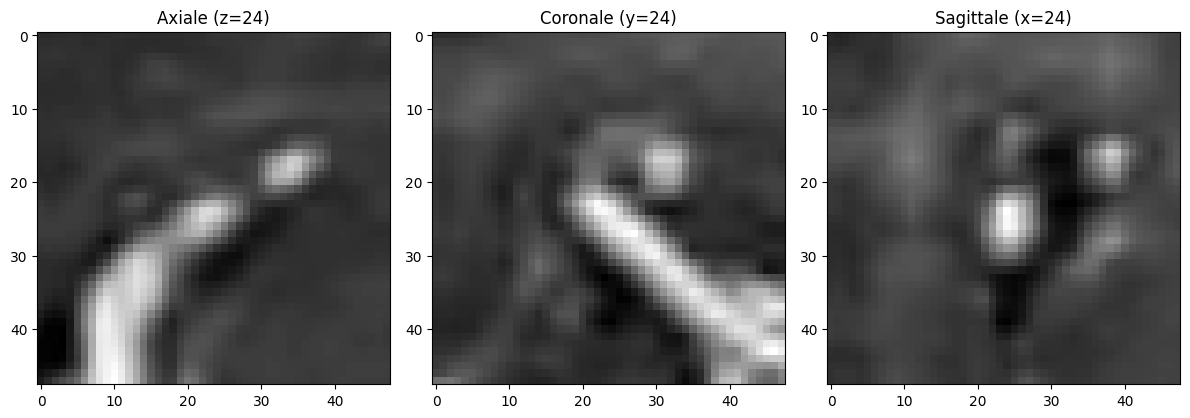

In [17]:
cube_deformed=random_deformation(cube_test)
show_middle_slices(cube_deformed)

In [22]:
cubes_augmented=data_augmentation(cube_test)

In [23]:
cubes_augmented.shape

(50, 48, 48, 48)

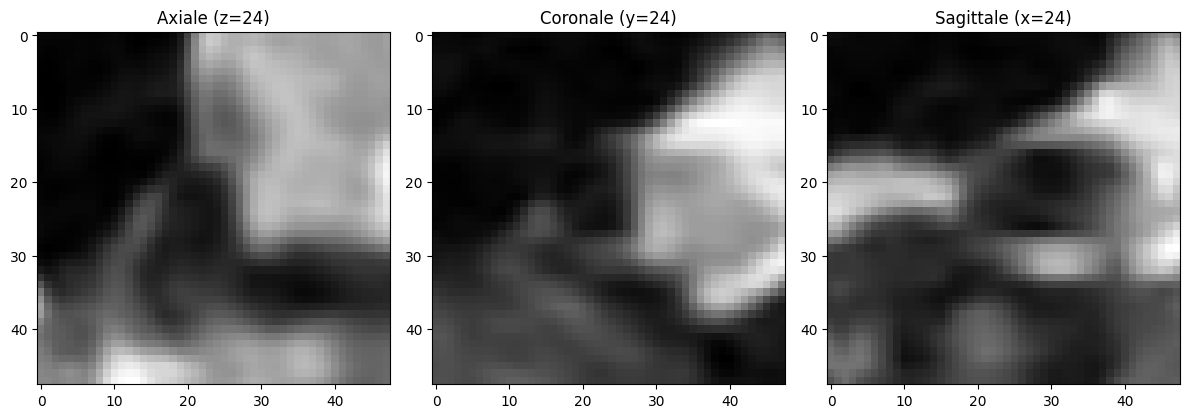

In [19]:
show_middle_slices(cubes_augmented[30])

In [26]:
df_positif=cubes_aneurysm.copy()
df_positif.shape

(84, 48, 48, 48)

In [29]:
df_positif_augmented=dataset_augmented(df_positif)

100%|██████████| 84/84 [08:17<00:00,  5.93s/it]


In [30]:
np.save("cubes_aneurysm_augmented_03_09.npy",df_positif_augmented)

In [31]:
df_positif_augmented.shape

(4200, 48, 48, 48)

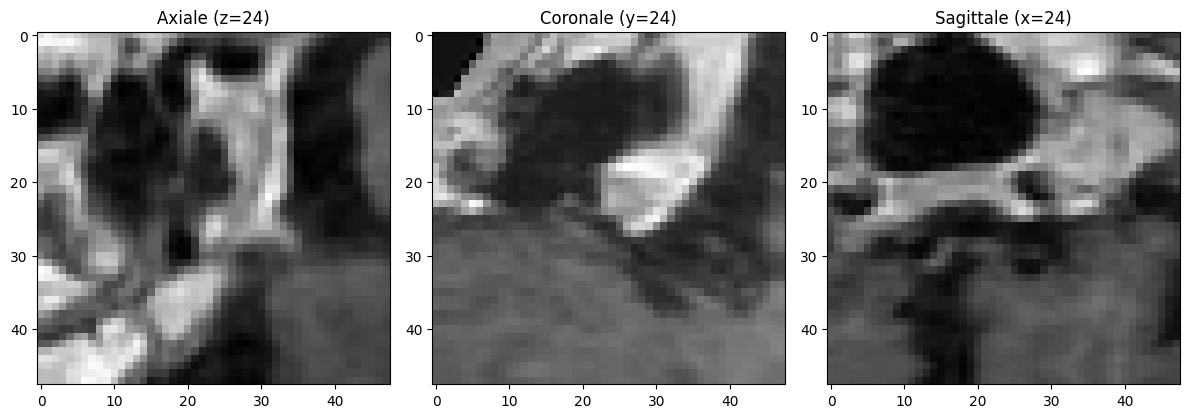

In [39]:
show_middle_slices(augmented_test[100])

In [35]:
df_hard_neg=hard_neg.copy()
print(df_hard_neg.shape)

(166, 48, 48, 48)


In [36]:
df_hard_neg_augmented=dataset_augmented(df_hard_neg)

100%|██████████| 166/166 [03:59<00:00,  1.44s/it]


In [37]:
np.save("cubes_hard_neg_augmented_03_09.npy",df_hard_neg_augmented)

In [38]:
df_hard_neg_augmented.shape

(1992, 48, 48, 48)

In [39]:
4200-1992

2208

In [40]:
n_samples = 1104

# Tirage aléatoire d'indices sans remise
indices = np.random.choice(cubes_closest.shape[0], size=n_samples, replace=False)

# Sélection des échantillons
random_samples_cubes_closest = cubes_closest[indices]

indices = np.random.choice(cubes_random.shape[0], size=n_samples, replace=False)
random_samples_cubes_random = cubes_random[indices]

In [42]:
random_samples_cubes_random.shape

(1104, 48, 48, 48)